In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({
    "axes.prop_cycle": plt.cycler("color", ['#000000', '#1b6989', '#e69f00', '#009e73', '#f0e442', '#50b4e9', '#d55e00', '#cc79a7']),
    "figure.figsize": [12.0, 5.0],
    "font.serif": ['Palatino',
                   'Palatino Linotype',
                   'Palatino LT STD',
                   'Book Antiqua',
                   'Georgia',
                   'DejaVu Serif'],
    'font.family': 'serif',
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Getting 1,000 samples of a linear regression model in different Probabilistic Programming Languages

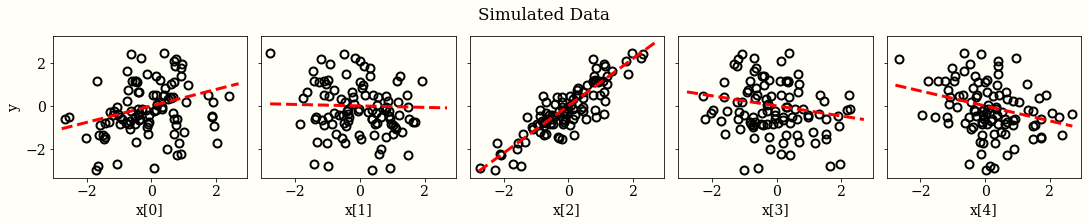

In [3]:
# Trailing underscore means the model has no access to the variable
np.random.seed(0)

ndims = 5
ndata = 100
X = np.random.randn(ndata, ndims)
w_ = np.random.randn(ndims)

noise_ = 0.1 * np.random.randn(ndata)
y_obs = X.dot(w_) + noise_


fig, axes = plt.subplots(sharey=True, ncols=ndims, figsize=(15, 3))

t = np.linspace(X.min(), X.max())
for idx, (ax, x) in enumerate(zip(axes.ravel(), X.T)):
    ax.plot(x, y_obs, 'o');
    ax.plot(t, w_[idx] * t, 'r--')
    ax.set_xlabel(f'x[{idx}]')
axes[0].set_ylabel('y')
fig.suptitle('Simulated Data');

## The Model

We have generated a linear regression dataset with 5 dimensions and 100 datapoints. 

In each library, we will define the joint probability distribution

$$
p(\mathbf{w}) \sim \mathcal{N}(\mathbf{0}, I_5)\\
p(\mathbf{y} | X, \mathbf{w}) \sim \mathcal{N}(X\mathbf{w}, 0.1I_{100}),
$$
where $I_5$ is a $5 \times 5$ identity matrix, and $I_{100}$ a $100 \times 100$ identity.

We then provide code to sample 1,000 draws from the posterior distribution: 

$$
p(\mathbf{w} | X, \mathbf{y}) \propto p(\mathbf{y} | X, \mathbf{w}) p(\mathbf{w})
$$

Note that in this case we can just do the math, and the actual posterior is

$$
p(\mathbf{w} | X, \mathbf{y}) = \mathcal{N}((X^TX + I_5)^{-1}X^Ty, (X^TX + I_5)^{-1})
$$



## PyMC3

- Uses `theano`
- Sampler is NUTS
- Does advanced tuning

```bash
pip install pymc3
```

https://docs.pymc.io/

In [4]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model():
    w = pm.Normal('w', 0, 1, shape=ndims)
    y = pm.Normal('y', tt.dot(X, w), 0.1, observed=y_obs)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 4172.07draws/s]


## PyStan

- Uses `Stan`, a stand-alone progamming language specialized to probabilistic programs
- Self-rolled auto-differentiation
- Sampler is NUTS
- Does advanced tuning

```bash
pip install pystan
```


https://pystan.readthedocs.io

In [5]:
import pystan

linear_regression = """
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of predictors
  matrix[N, K] X;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  vector[K] w;       // coefficients for predictors
}
model {
  y ~ normal(X * w, 0.1);  // likelihood
}
"""

linear_data = {'N': ndata,
               'K': ndims,
               'y': y_obs,
               'X': X
              }

sm = pystan.StanModel(model_code=linear_regression)
fit = sm.sampling(data=linear_data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_37b8e41c9d58148edcdc9d099a42ee4b NOW.


In [6]:
pystan.__version__

'2.19.0.0'

## emcee

- Affine invariant ensemble MCMC sampler
- No gradients - limited scaling with dimension
- Well tested, easy to install

```bash
pip install emcee
```

https://emcee.readthedocs.io

In [7]:
import scipy.stats as st

import emcee

# log likelihood
def lnlike(w, X, y):
    model = X.dot(w) 
    inv_sigma2 = 0.1 ** -2
    return -0.5*(np.sum((y-model)**2)*inv_sigma2 - np.log(inv_sigma2))

# Define a prior for w
w_rv = st.multivariate_normal(np.zeros(ndims), np.eye(ndims))

# Log probability for w
lnprior = w_rv.logpdf

# logp(w | X, y) = logp(y | X, w) + logp(w)
def lnprob(w, X, y):
    return lnprior(w) + lnlike(w, X, y)

nwalkers = 100
pos = w_rv.rvs(size=nwalkers)
sampler = emcee.EnsembleSampler(nwalkers, ndims, lnprob, args=(X, y_obs))

pos, lprob, rstate  = sampler.run_mcmc(pos, 1000)

In [8]:
emcee.__version__

'3.0.0'

## Tensorflow Probability

- "scipy-stats, with gradients"
- Also has MCMC algorithms, keras layers with uncertainty
- Built on tensorflow, well integrated into ecosystem
- Has NUTS, HMC, _some_ tuning
- Massively parallel

```bash
pip install tensorflow-probability
```
https://www.tensorflow.org/probability

In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

X_tensor = tf.convert_to_tensor(X, dtype='float32')

@tf.function
def target_log_prob_fn(w):
    w_dist = tfd.Normal(loc=tf.zeros((ndims, 1)), scale=1.0, name="w")
    w_prob = tf.reduce_sum(w_dist.log_prob(w))
    y_dist = tfd.Normal(loc=tf.matmul(X_tensor, w), scale=0.1, name="y")
    y_prob = tf.reduce_sum(y_dist.log_prob(y_obs.reshape(-1, 1)))
    return w_prob + y_prob


# Initialize the HMC transition kernel.
num_results = 1000
num_burnin_steps = 500
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        num_leapfrog_steps=4,
        step_size=0.01),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

samples, is_accepted = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=tf.zeros((ndims, 1)),
    kernel=adaptive_hmc,
    trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

In [10]:
tfp.__version__

'0.8.0'

## Pyro

- Built on pytorch
- Has HMC, NUTS, not sure on tuning
- Used to be focused on variational inference, has done more MCMC

```bash
install pyro-ppl 
```

https://pyro.ai/

In [11]:
import pyro
import torch
from pyro.infer.mcmc import NUTS, MCMC
import pyro.distributions as dist


def model(X):
    w = pyro.sample('w', dist.Normal(torch.zeros(ndims), torch.ones(ndims)))
    y = pyro.sample('y', dist.Normal(torch.matmul(X, w), 0.1 * torch.ones(ndata)), obs=torch.as_tensor(y_obs, dtype=torch.float32))
    return y

nuts_kernel = NUTS(model, adapt_step_size=True)
py_mcmc = MCMC(nuts_kernel, num_samples=1_000, warmup_steps=500)

py_mcmc = py_mcmc.run(torch.as_tensor(X, dtype=torch.float32))

sample: 100%|██████████| 1500/1500 [00:08<00:00, 167.07it/s, step size=6.77e-01, acc. prob=0.898]


In [12]:
pyro.__version__

'0.5.0'

## Numpyro

- Built on `jax`
- Same team as pyro
- Has NUTS, HMC
- Small and quick

```bash
pip install git+https://github.com/pyro-ppl/numpyro.git
```

In [13]:
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS


def model(X=None):
    w = numpyro.sample('w', dist.Normal(jnp.zeros(ndims), jnp.ones(ndims)))
    y = numpyro.sample('y', dist.Normal(jnp.dot(X, w), 0.1 * jnp.ones(ndata)), obs=jnp.array(y_obs))
    return y

rng_ = random.PRNGKey(0)

kernel = NUTS(model)
mcmc = MCMC(kernel, 500, 1000)
mcmc.run(rng_, X=X)

sample: 100%|██████████| 1500/1500 [00:04<00:00, 349.88it/s, 7 steps of size 6.72e-01. acc. prob=0.90]


In [14]:
numpyro.__version__

'0.2.0'

## Brancher

- Doesn't actually implement MCMC, I think. Does variational inference.
- Beautiful!
- Built on pytorch

```python
pip install brancher
```

https://brancher.org/

In [15]:
from brancher.variables import ProbabilisticModel
from brancher.standard_variables import NormalVariable
from brancher import inference
import brancher.functions as BF

import torch

# Model
w = NormalVariable(loc=torch.zeros(ndims), scale=1., name="w")
y = NormalVariable(loc=BF.matmul(torch.as_tensor(X, dtype=torch.float32), w), scale=0.1, name="y")

y.observe(y_obs)
model = ProbabilisticModel([w, y])

## Edward 2

- Built on tensorflow and tensorflow probability
- Mostly a model building language!
- Installed with tensorflow probability, for 2 more months
- Inference is with tensorflow probability

```bash
pip install git+https://github.com/google/edward2.git
```

In [16]:
import edward2 as ed
import tensorflow as tf

X_tensor = tf.convert_to_tensor(X, dtype='float32')

def linear_regression(X):
    """Bayesian logistic regression p(y | x) = int p(y | x, w, b) p(w, b) dwdb."""
    w = ed.Normal(loc=tf.zeros((ndims, 1)), scale=1.0, name="w")
    y = ed.Normal(loc=tf.matmul(X, w), scale=0.1, name='y')
    return y

log_joint = ed.make_log_joint_fn(linear_regression)


def target_log_prob_fn(w):
    """Target log-probability as a function of states."""
    return log_joint(X_tensor,
                     w=w,
                     y=y_obs.reshape(-1, 1))

# Initialize the HMC transition kernel.
num_results = 1000
num_burnin_steps = 500

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        num_leapfrog_steps=4,
        step_size=0.01),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

ed_samples, is_accepted = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=tf.zeros((ndims, 1)),
    kernel=adaptive_hmc,
    trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

## PyMC4
- Built on tensorflow and tensorflow probability
- Very alpha
- Mostly a modelling layer still
- Uses HMC, and the tuning is still not very good!

```bash
pip install git+https://github.com/pymc-devs/pymc4.git
```

In [17]:
import pymc4

@pymc4.model()
def linear_model():
    w = yield pymc4.distributions.Normal('w', loc=np.zeros((5, 1)), scale=1.)
    y = yield pymc4.distributions.Normal('y', loc=tf.matmul(X, w), scale=0.1)
    
trace = pymc4.inference.sampling.sample(linear_model())

In [18]:
pymc4.__version__

'0.0.1'